In [13]:
from os import listdir
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

from plot_helpers import comparison_plot_summary
from preprocessing_helpers import minMax, get_smoothed_data, get_LPF_filtered_data

# Dataset & Preprocessing

## Load Data

In [14]:
# LOAD DATA
folder_path = './CMAPS/'
listdir(folder_path)
df_train_fd001 = pd.read_csv(folder_path + 'train_FD001.txt', header = None, sep = ' ')
df_test_fd001  = pd.read_csv(folder_path + 'test_FD001.txt', header = None, sep = ' ')
rul_test_fd001 = pd.read_csv(folder_path + 'RUL_FD001.txt', header = None)

df_train_fd001 = df_train_fd001.iloc[:,:-2].copy()
df_test_fd001  = df_test_fd001.iloc[:,:-2].copy()


col_names = [
  'Engine Unit',
  'time',
  'os1','os2','os3',
  'Fan Inlet Temp',                           #s1
  'LPC Outlet Temp',                          #s2
  'HPC Outlet Temp',                          #s3
  'LPT Outlet Temp',                          #s4
  'Fan Inlet Pressure',                       #s5
  'Bypass-Duct Pressure',                     #s6
  'HPC Outlet Pressure',                      #s7
  'Physical Fan Speed',                       #s8
  'Physical Core Speed',                      #s9
  'Engine Pressure Ratio (P50/P2)',           #s10
  'HPC Outlet Static Pressure',               #s11
  'Ratio of Fuel Flow to Ps30 (pps/psia)',    #s12
  'Corrected Fan Speed',                      #s13
  'Corrected Core Speed',                     #s14
  'Bypass Ratio',                             #s15
  'Burner Fuel-Air Ratio',                    #s16
  'Bleed Enthalpy',                           #s17
  'Required Fan Speed',                       #s18
  'Required Fan Conversion Speed',            #s19
  'High-Pressure Turbines Cool Air Flow',     #s20
  'Low-Pressure Turbines Cool Air Flow'       #s21
]
df_train_fd001.columns = col_names
df_test_fd001.columns = col_names
 

In [15]:
# Get data frames & rul lists
def get_rul_test_train(_df_test, _rul_test, _df_train):
  rul_list_train = []
  for n in np.arange(1,101):
      time_list = np.array(_df_train[_df_train['Engine Unit'] == n]['time'])
      length = len(time_list)
      rul = list(length - time_list)
      rul_list_train += rul
  rul_list_test = []

  for n in np.arange(1,101):
      time_list = np.array(_df_test[_df_test['Engine Unit'] == n]['time'])
      length = len(time_list)
      rul_val = _rul_test.iloc[n-1].item()
      rul = list(length - time_list + rul_val)
      rul_list_test += rul
  return rul_list_test, rul_list_train
df_test  = df_test_fd001
df_train = df_train_fd001
rul_test = rul_test_fd001
rul_list_test, rul_list_train = get_rul_test_train(df_test, rul_test, df_train)
df_test['rul'], df_train['rul'] = rul_list_test, rul_list_train

## Selecting Features

In [16]:
# 1) Chose features
drop_cols1 = [
  'os3',
  'Fan Inlet Temp',                           #s1
  'Fan Inlet Pressure',                       #s5
  'Bypass-Duct Pressure',                     #s6
  'Engine Pressure Ratio (P50/P2)',           #s10
  'Burner Fuel-Air Ratio',                    #s16
  'Required Fan Speed',                       #s18
  'Required Fan Conversion Speed',            #s19
]
df_train = df_train.drop(drop_cols1, axis = 1)
df_test = df_test.drop(drop_cols1, axis = 1)

## Preprocessing

In [17]:
# 2) MinMax Scaling
df_train = minMax(df_train)
df_test  = minMax(df_test)

In [18]:
# 3) Smoothing: Exponentially Weighted Average
df_train_smoothed, df_test_smoothed = get_smoothed_data(df_train, df_test)

In [19]:
# 4) Low Pass Filter
df_train_LPF, df_test_LPF = get_LPF_filtered_data(df_train, df_test, cutoff_low=12, fs=1000, order=5)

## Sampling Data

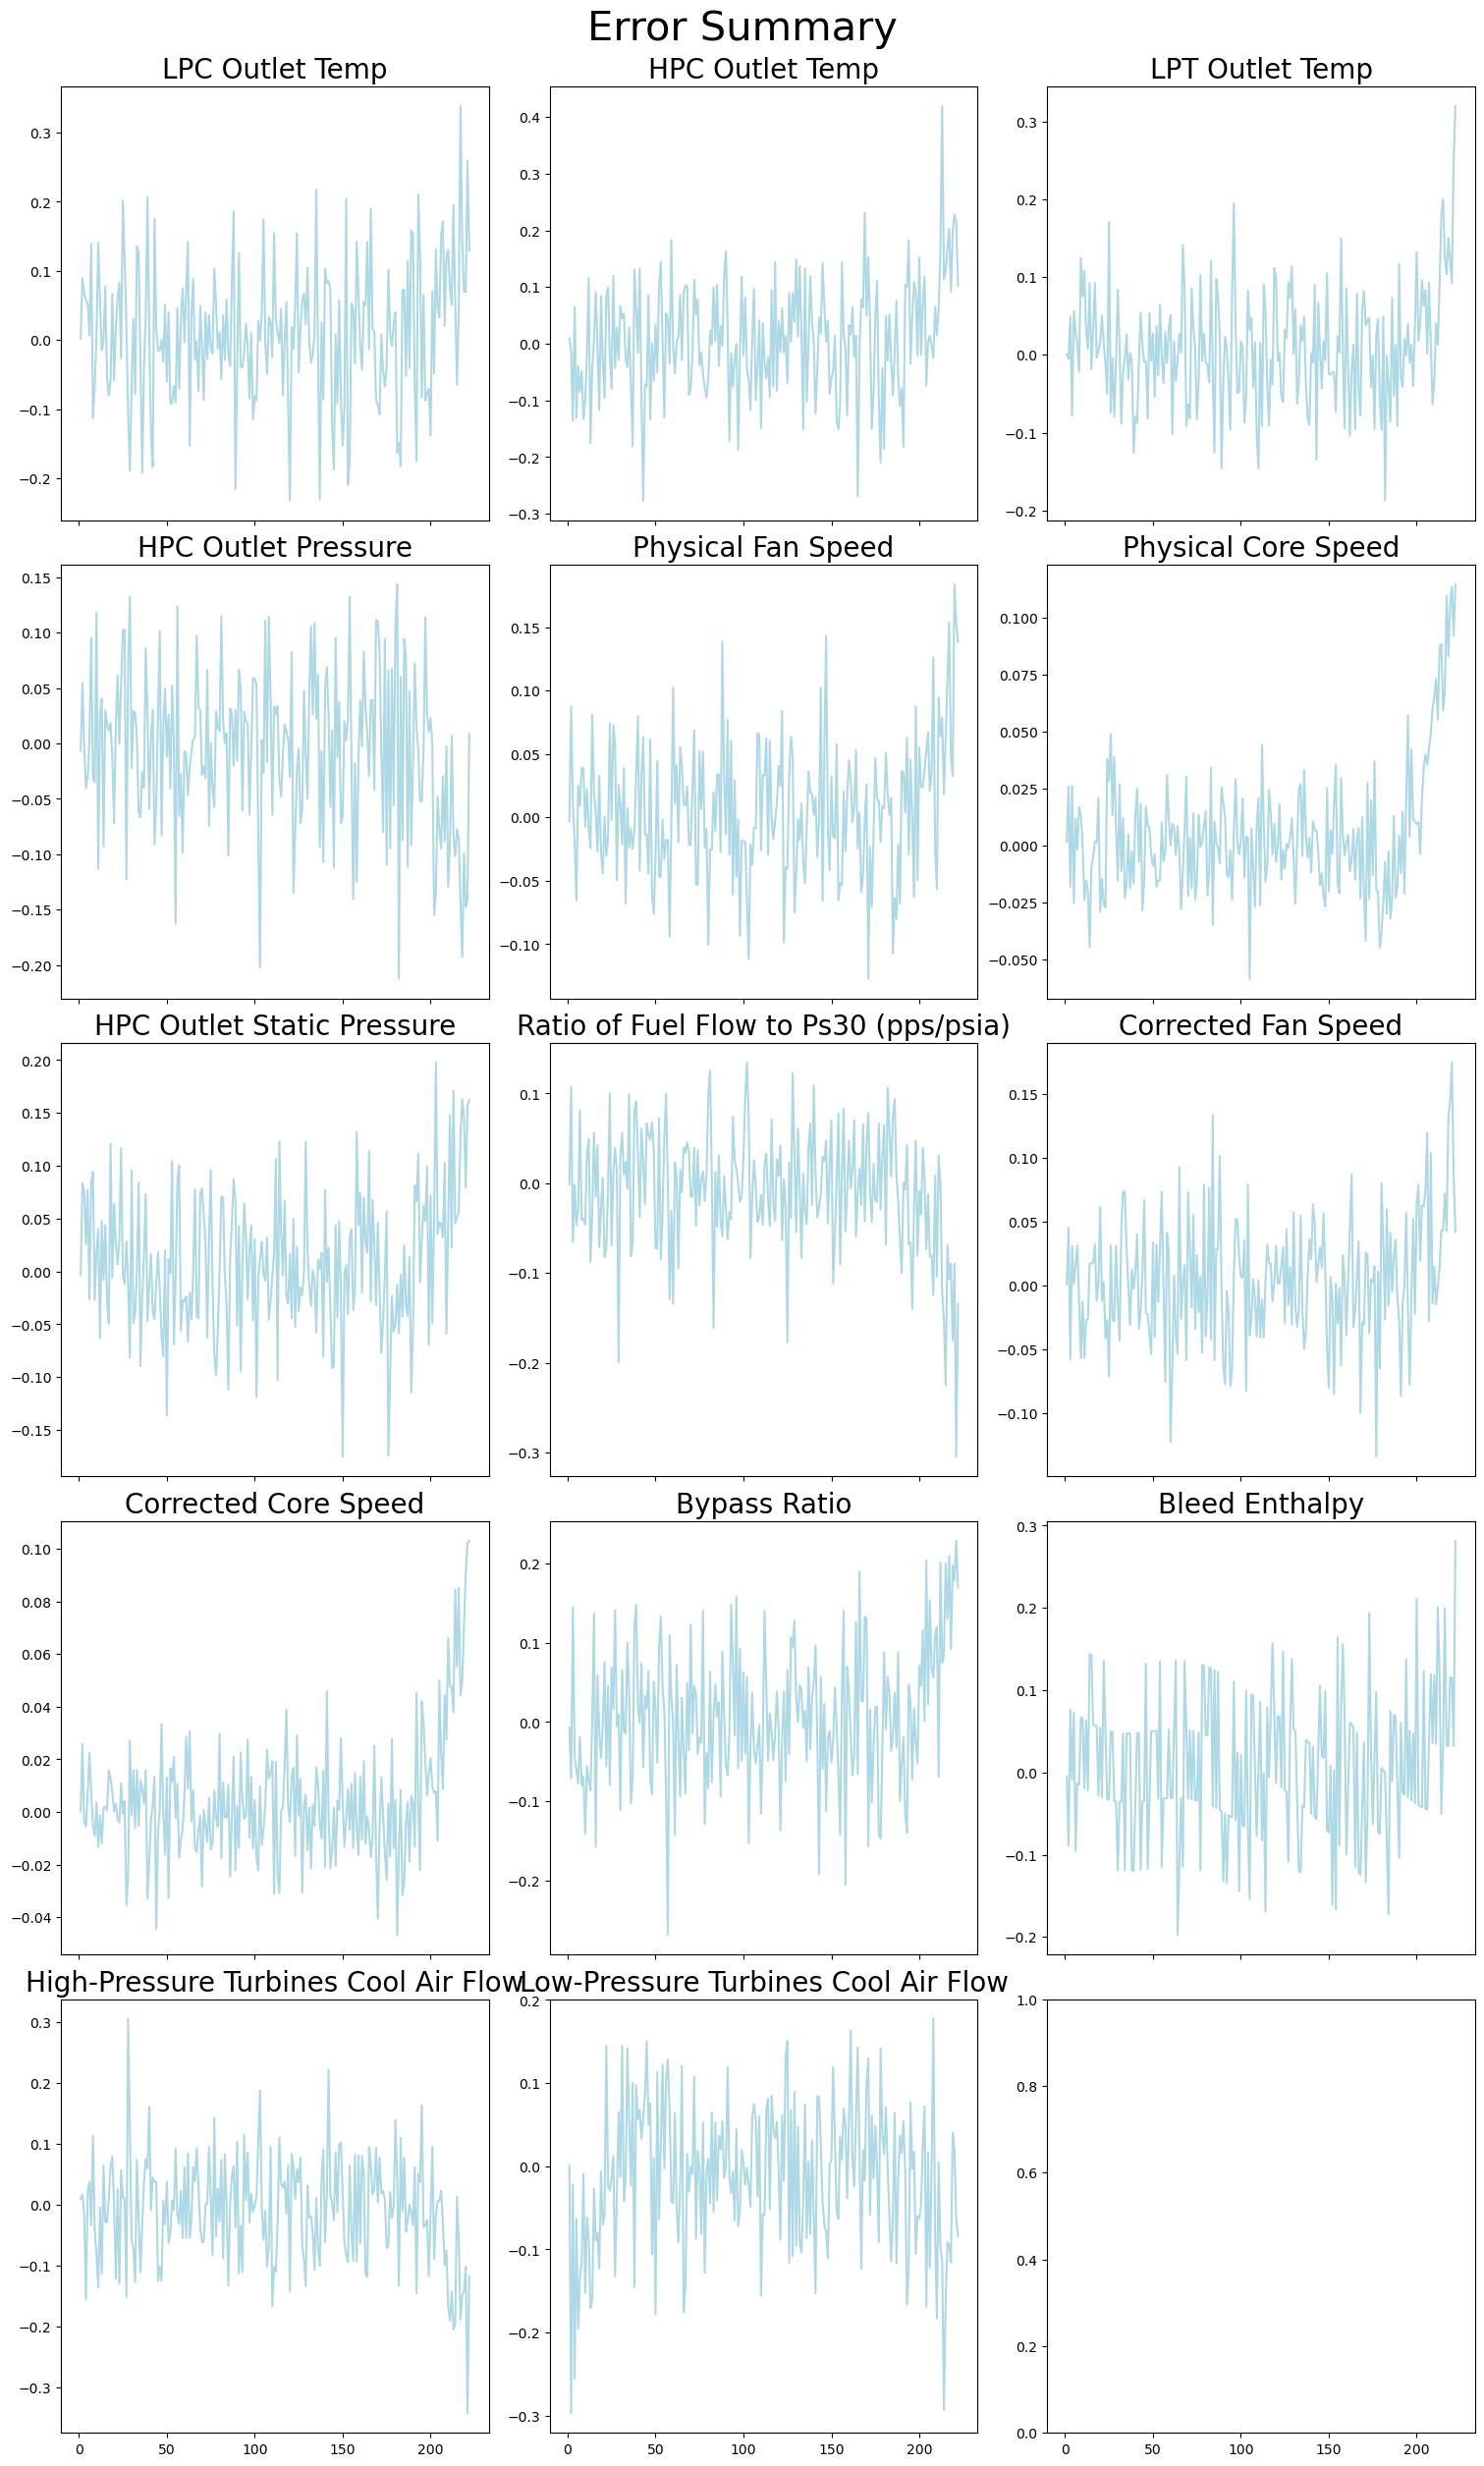

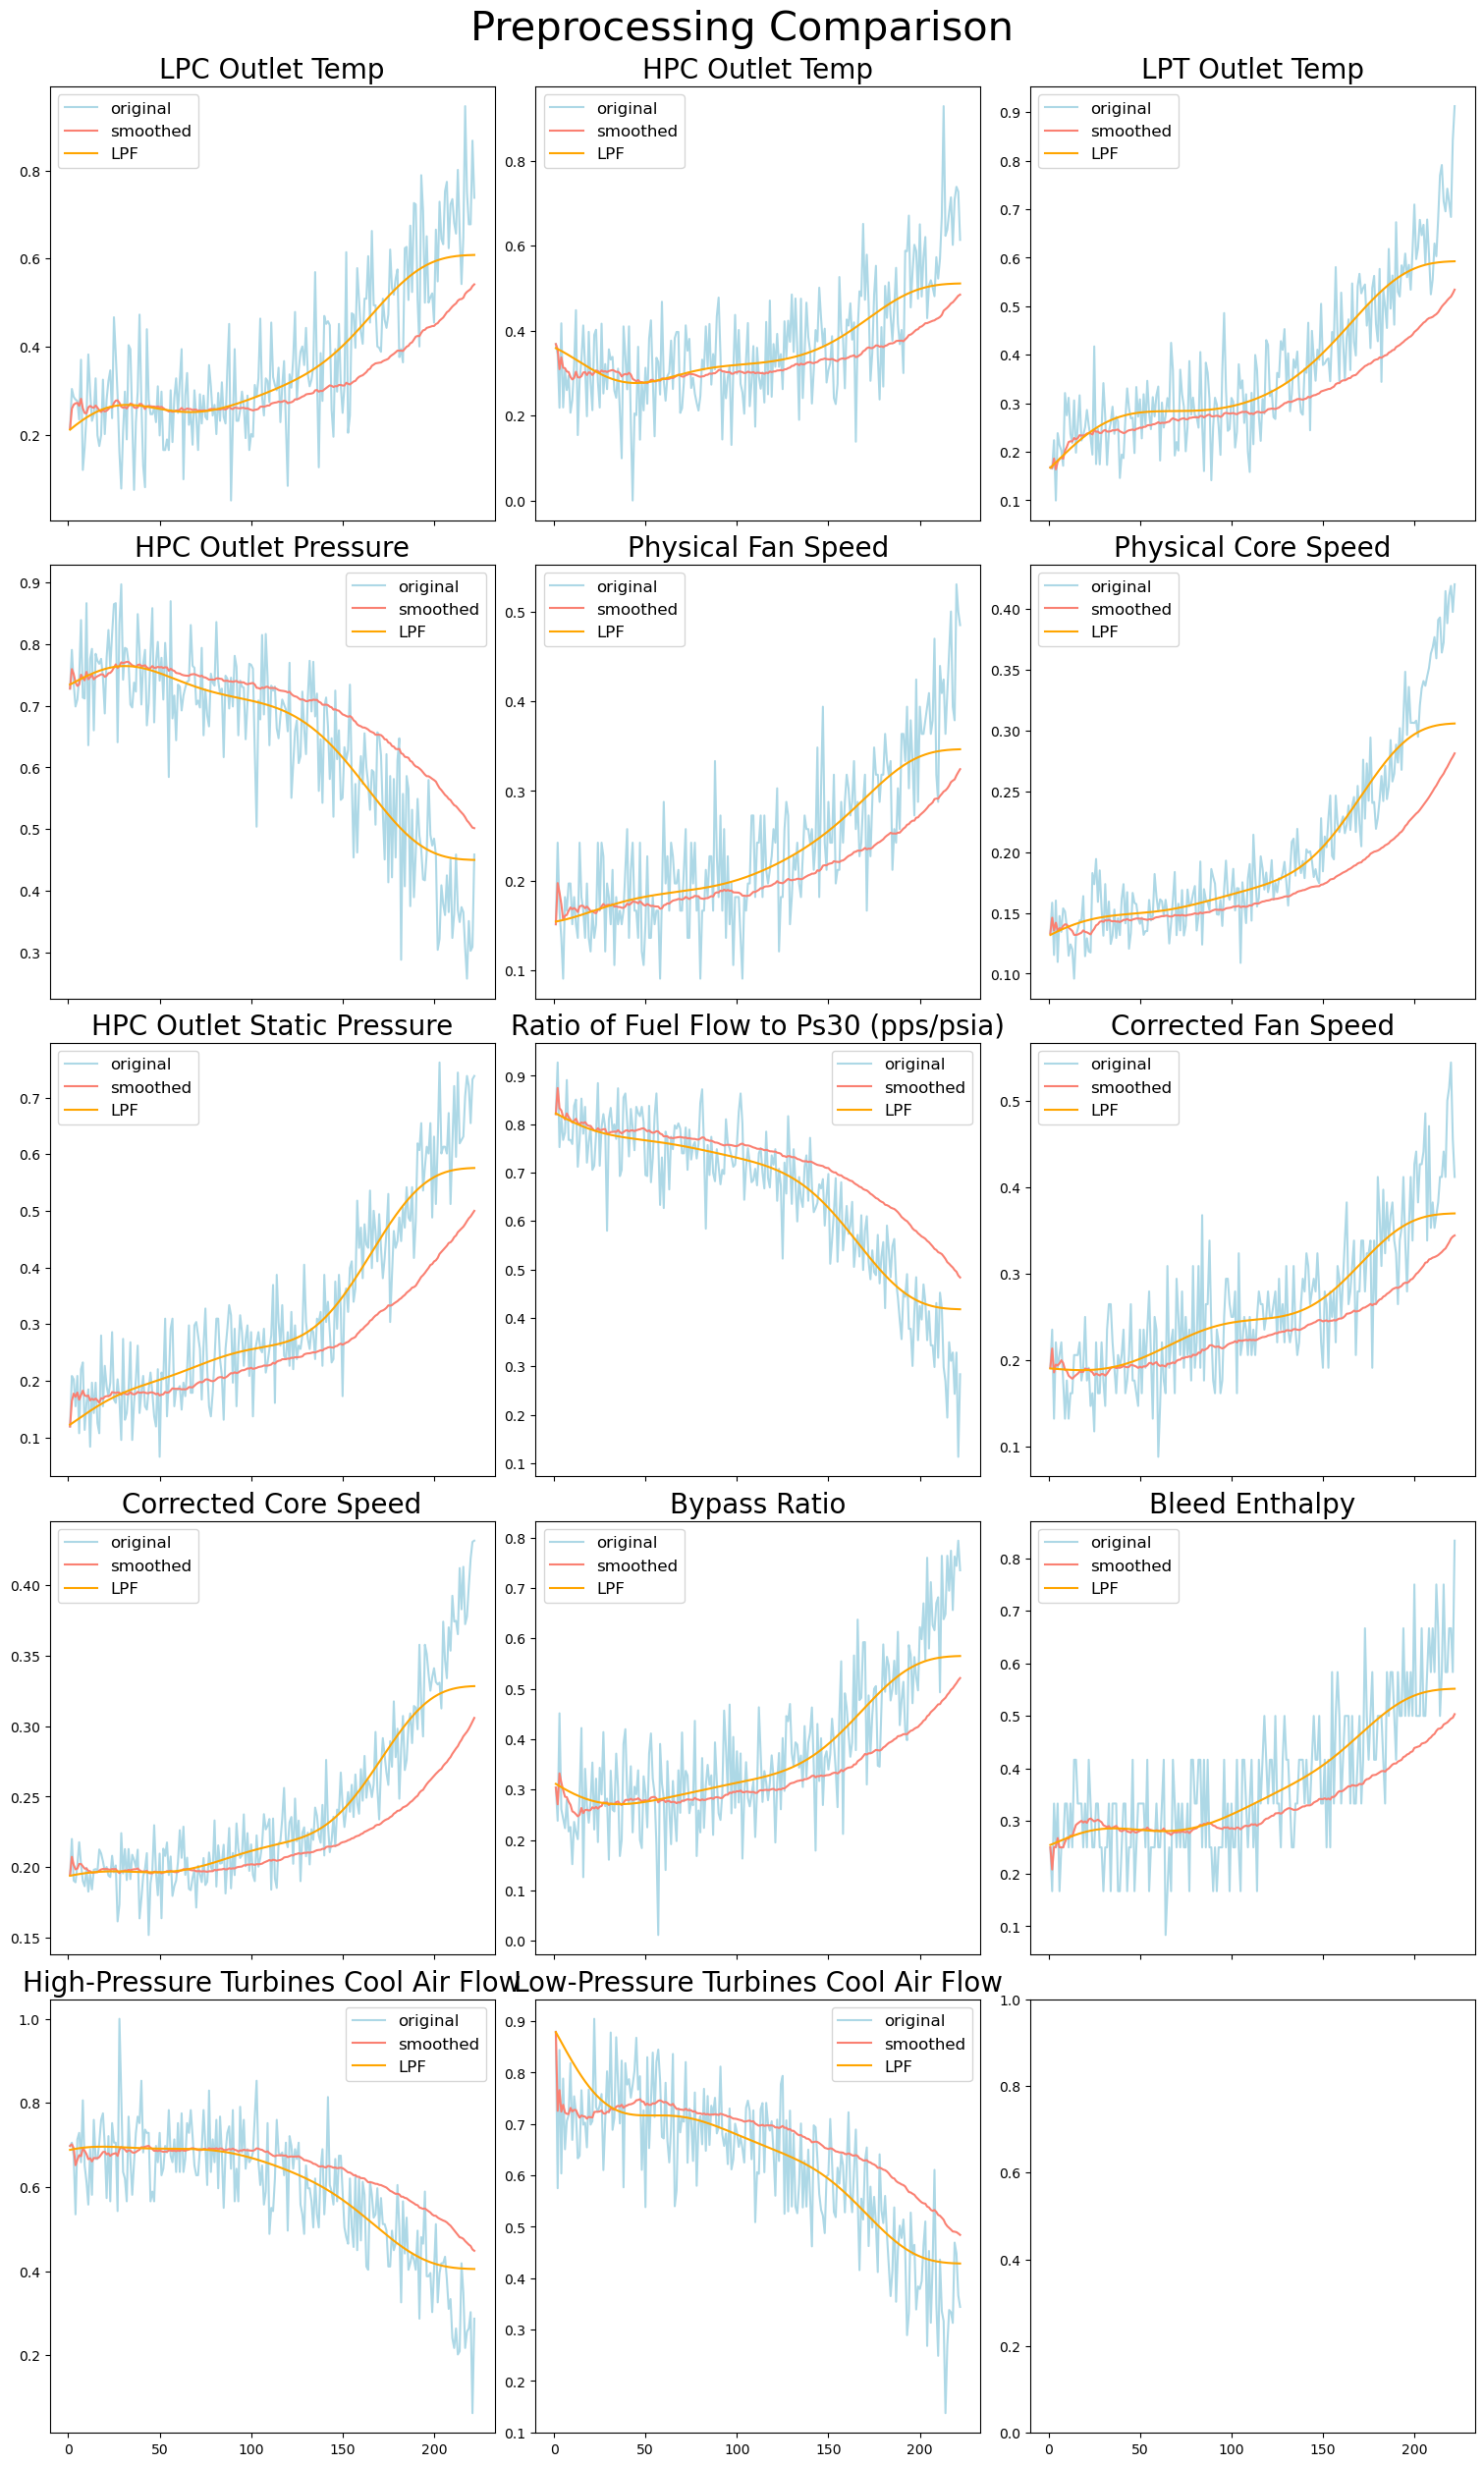

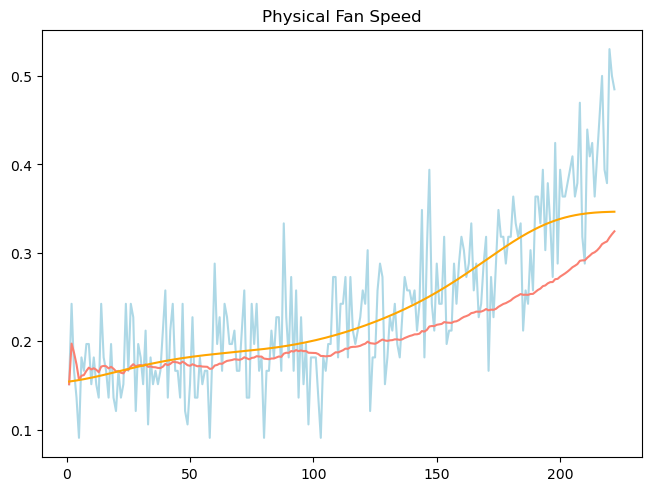

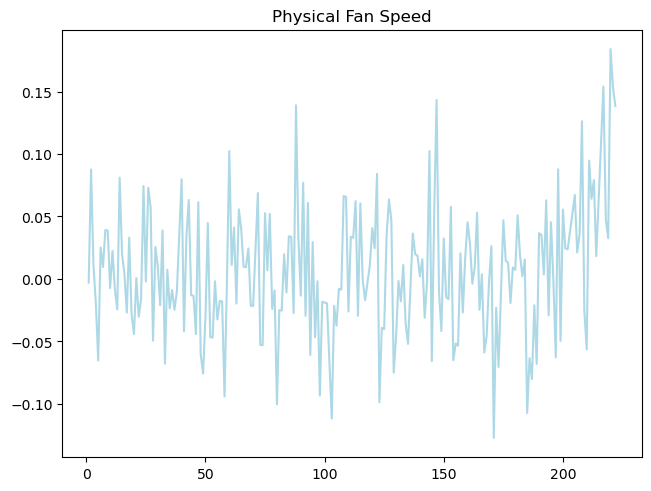

In [20]:
# Sample Data
sample = 10
sample_df               = df_train[df_train['Engine Unit'] == sample].copy()
smoothed_sample_df      = df_train_smoothed[df_train_smoothed['Engine Unit'] == sample].copy()
LPF_sample_df           = df_train_LPF[df_train_LPF['Engine Unit'] == sample].copy()
samples = [sample_df,smoothed_sample_df,LPF_sample_df]
labels = ['original','smoothed','LPF']
comparison_plot_summary(samples, labels)

# LSTM

In [ ]:
import torch
from torch.utils.data import DataLoader
from learning_utils import get_dataLoader, data_test, train_model, err_analysis
from lstm_helpers import  get_model_training_helpers
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Model Parameters

In [21]:
# 1) Model Parameters
n_features = len(df_train.columns[2:-1])
window = 20
print(f'number of features: {n_features}, window size: {window}')
np.random.seed(5)
units = np.arange(1,101)
train_units = list(np.random.choice(units, 80, replace = False))
val_units = list(set(units) - set(train_units))
print(val_units)

## Original signal

In [22]:
# 2) Original Model
train_data = df_train[df_train['Engine Unit'].isin(train_units)].copy()
val_data = df_train[df_train['Engine Unit'].isin(val_units)].copy()
trainloader,valloader = get_dataLoader(train_data, val_data, df_train, window)
test = data_test(units, df_test)
testloader = DataLoader(test, batch_size = 100)
model, loss_fn, optimizer = get_model_training_helpers(n_features, device)
train_model(model, trainloader, valloader, device, optimizer, loss_fn, epochs=100)        

# Load Models
model.load_state_dict(torch.load('model.pth'))

# Error Analysis
err_analysis(model, loss_fn, testloader, device, _name='original')

NameError: name 'train_units' is not defined

## Smoothed Signal

In [ ]:
# 3) Smoothed Model
train_data_sm = df_train_smoothed[df_train_smoothed['Engine Unit'].isin(train_units)].copy()
val_data_sm = df_train_smoothed[df_train_smoothed['Engine Unit'].isin(val_units)].copy()
trainloader_sm,valloader_sm = get_dataLoader(train_data_sm, val_data_sm, df_train_smoothed, window)
test_sm = data_test(units, df_test)
testloader_sm = DataLoader(test_sm, batch_size = 100)
model_sm, loss_fn_sm, optimizer_sm = get_model_training_helpers(n_features, device)
train_model(model_sm, trainloader_sm, valloader_sm, device, optimizer_sm, loss_fn_sm, epochs=100)

# Load Models
model_sm.load_state_dict(torch.load('model_smoothed.pth'))

err_analysis(model_sm, loss_fn_sm, testloader_sm, device, _name='smoothed')

## Filtered Signal (Low Pass Filter)

In [ ]:
# 4) LPF Model
train_data_LPF = df_train_LPF[df_train_LPF['Engine Unit'].isin(train_units)].copy()
val_data_LPF = df_train_LPF[df_train_LPF['Engine Unit'].isin(val_units)].copy()
trainloader_LPF,valloader_LPF = get_dataLoader(train_data_LPF, val_data_LPF, df_train_LPF, window)
test_LPF = data_test(units, df_test)
testloader_LPF = DataLoader(test_LPF, batch_size = 100)
model_LPF, loss_fn_LPF, optimizer_LPF = get_model_training_helpers(n_features, device)
train_model(model_LPF, trainloader_LPF, valloader_LPF, device, optimizer_LPF, loss_fn_LPF, epochs=100)

# Load Models
model_LPF.load_state_dict(torch.load('model_LPF.pth'))

err_analysis(model_LPF, loss_fn_LPF, testloader_LPF, device, _name='LPF')